### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jan 20 16:48:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 83.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 128.1 MB/s eta 0:00:00


## Download dataset from Roboflow Universe

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KCQ0QBYpgMr3MzWVkqE4")
project = rf.workspace("potholes-r7qcn").project("pothole-jujbl")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in yolov12:: 100%|██████████| 5554/5554 [00:00<00:00, 5939.09it/s]


In [5]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole']

roboflow:
  workspace: potholes-r7qcn
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [19]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.4.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Pothole-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

train: Scanning /content/Pothole-1/train/labels.cache... 1939 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1939/1939 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Pothole-1/valid/labels.cache... 555 images, 4 backgrounds, 0 corrupt: 100%|██████████| 555/555 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.9G       3.49      3.806      3.968          8        640: 100%|██████████| 122/122 [01:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449    0.00187      0.215    0.00136   0.000487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.92G      2.974      3.426      3.261          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.33it/s]


                   all        555       1449     0.0137      0.373     0.0152      0.004

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.98G      2.772      3.218      2.954          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449     0.0644      0.135      0.031    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.92G       2.67      3.123      2.806         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


                   all        555       1449      0.123      0.131     0.0498     0.0143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.94G      2.546      2.993      2.676          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


                   all        555       1449     0.0724     0.0642     0.0252    0.00895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.73G      2.422      2.886      2.577         22        640: 100%|██████████| 122/122 [01:03<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


                   all        555       1449       0.15      0.166     0.0942      0.031

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.93G      2.353      2.752      2.497          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449     0.0429      0.078     0.0158    0.00501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.91G      2.275      2.694      2.416         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449      0.238      0.237      0.181     0.0664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.81G      2.176      2.579      2.334         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


                   all        555       1449      0.242      0.184       0.15     0.0553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.74G      2.156      2.532      2.279         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449       0.26      0.245      0.171     0.0614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.75G      2.095      2.456      2.236         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.358      0.307      0.257      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.74G      2.064      2.413      2.187         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.254      0.228      0.155     0.0564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.96G      2.025      2.327      2.141          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.396      0.331      0.307       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.74G      2.011      2.319      2.124         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.422      0.315      0.316      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.78G      2.002      2.304      2.105          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.57it/s]


                   all        555       1449      0.355      0.314      0.271       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.76G      1.979      2.284      2.074         15        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449      0.385      0.324      0.312       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.76G      1.954      2.236      2.048         30        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]

                   all        555       1449      0.458      0.357      0.334      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.88G      1.924      2.222      2.042         16        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.54it/s]


                   all        555       1449      0.434      0.329      0.335      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.94G       1.89      2.149       1.99         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.466      0.349      0.358      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.9G      1.888       2.15      1.989         17        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449      0.443      0.371      0.377      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.79G      1.888      2.129       1.99         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.427      0.338      0.321      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       6.9G       1.86      2.126      1.972          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449       0.47      0.369       0.38      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.95G      1.838      2.088      1.939         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.417      0.378      0.361      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.93G      1.851      2.081      1.944         23        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.477      0.378      0.368      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.92G      1.848      2.045       1.93         27        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]

                   all        555       1449      0.497      0.409      0.425      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.92G      1.815      2.023      1.911         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


                   all        555       1449      0.506      0.396      0.409      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.94G      1.798      2.025      1.898         18        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.552      0.431      0.465      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.92G      1.809      2.001      1.892          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.537      0.418      0.465      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.95G      1.764      1.944      1.862          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.529       0.43      0.448      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.91G      1.773      1.973      1.872         16        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.54it/s]

                   all        555       1449      0.525      0.412      0.453      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.93G      1.769       1.94      1.859          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.517      0.468      0.466      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.93G      1.742      1.905      1.825         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.536       0.47      0.494      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.97G      1.741       1.87      1.836         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]

                   all        555       1449      0.565      0.436      0.495      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.79G      1.749      1.887      1.844         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.528      0.442      0.477      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.94G      1.727      1.861      1.825          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.605      0.454      0.511      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.92G      1.717      1.853      1.805         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.566      0.473      0.507      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.95G      1.696      1.822      1.786          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.557      0.484      0.513      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.92G      1.717      1.801      1.789         17        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.568      0.505      0.535      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.81G        1.7      1.806      1.786         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.562      0.492      0.521      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       6.9G      1.694      1.799      1.782         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.559      0.494      0.529      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.93G      1.702      1.825       1.79          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]

                   all        555       1449      0.583      0.464      0.519      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.92G      1.695      1.782      1.774         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


                   all        555       1449      0.588      0.512      0.557       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.92G      1.656      1.785      1.751          4        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.557      0.472      0.513      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.92G      1.679      1.764      1.763         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


                   all        555       1449      0.562      0.473      0.504      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.94G      1.676      1.766       1.76         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.606      0.498      0.546      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.95G      1.666      1.732      1.755          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449      0.572      0.491       0.54      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.93G      1.659      1.725      1.738          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.593        0.5      0.551      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.95G      1.635      1.732      1.728         21        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449       0.59      0.479      0.541      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.96G      1.638      1.715      1.726         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


                   all        555       1449      0.593      0.487      0.538      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.91G      1.647      1.708      1.722         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449       0.62       0.54      0.594      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.98G      1.644      1.718      1.746         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.562      0.518      0.546      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.93G      1.623      1.678      1.712          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.532      0.505      0.514      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.96G      1.639      1.681      1.712         31        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.612      0.549      0.592      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.91G      1.613      1.658      1.705          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        555       1449      0.638      0.507      0.582      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.93G       1.61      1.666      1.694         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.598      0.558      0.593      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.93G      1.588      1.635      1.685         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.601      0.562      0.596      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.96G      1.607      1.678      1.706          3        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]

                   all        555       1449      0.608      0.538      0.574        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.9G      1.592       1.64      1.688         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449       0.63      0.529      0.598      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.94G      1.602      1.628      1.692         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.634      0.534      0.586      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.91G      1.585      1.591      1.665         16        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.653      0.523      0.587       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.97G      1.582      1.623      1.675         17        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


                   all        555       1449      0.618      0.535      0.583      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.89G      1.584      1.611      1.678         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.656      0.534      0.614      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.77G      1.579      1.592      1.663         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


                   all        555       1449      0.634      0.562      0.612      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.77G      1.577      1.593      1.666         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.624      0.562      0.616      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.92G      1.553      1.565      1.645         22        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.655      0.545      0.621      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.91G      1.556      1.545      1.651         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449      0.637      0.555       0.61      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.95G      1.552       1.55      1.653          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449       0.61      0.555      0.602      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.76G      1.548      1.552      1.638         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


                   all        555       1449      0.652      0.539      0.614      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.78G      1.552      1.546      1.644         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449      0.634      0.564      0.608      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.94G      1.551      1.537       1.64         15        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


                   all        555       1449      0.663      0.521      0.605      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.94G      1.526      1.526      1.627         13        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        555       1449      0.631      0.531      0.604      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.91G      1.527       1.52      1.623          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.649      0.572      0.626      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.93G      1.529      1.508      1.621          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.677      0.573      0.646      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.92G      1.526      1.515       1.62          4        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]

                   all        555       1449      0.681      0.587      0.651      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.77G      1.523      1.504      1.617         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449      0.647      0.562      0.631      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.9G      1.518      1.492      1.623          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449       0.66      0.591      0.645      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       6.8G      1.513      1.494      1.621          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449       0.67      0.581       0.64      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.95G      1.528      1.499      1.623         18        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.701      0.545      0.651       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.93G      1.514       1.49      1.605         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.659      0.573       0.64      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.91G      1.495      1.475        1.6         22        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449      0.672      0.581      0.652      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.95G      1.501      1.465        1.6          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.54it/s]


                   all        555       1449      0.667      0.595       0.66      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.92G      1.496      1.452      1.606          5        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


                   all        555       1449      0.655      0.602      0.654      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.94G      1.488      1.445      1.584          8        640: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.663      0.601      0.667      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.91G      1.503      1.465      1.602         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        555       1449      0.682      0.592      0.661      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.95G      1.486      1.445      1.595         12        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]

                   all        555       1449      0.677      0.592      0.651      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.93G      1.488      1.439      1.584          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.653      0.616      0.665      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.95G      1.472      1.411      1.581          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.666      0.602      0.665      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.92G      1.479      1.437      1.591         14        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449      0.682      0.605      0.673       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.94G      1.471      1.416      1.582         11        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.683      0.598      0.672      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.93G      1.471      1.415       1.58          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]

                   all        555       1449      0.689      0.612       0.68      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.95G      1.445      1.361      1.578          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449       0.67      0.618      0.674       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.88G      1.428      1.332      1.566         10        640: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.696      0.605      0.679      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.93G      1.422      1.311      1.569          4        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]

                   all        555       1449       0.68      0.616       0.68      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.95G      1.416      1.294      1.558          8        640: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449      0.699      0.617      0.691      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.74G      1.404      1.299      1.549          7        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.716      0.607       0.69      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.9G      1.402      1.281      1.548          9        640: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]

                   all        555       1449      0.701      0.618      0.694      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.76G      1.408      1.268      1.536         11        640: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449       0.71      0.629      0.697      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.88G      1.393      1.263      1.532          5        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.718      0.622      0.698      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.91G      1.389      1.265      1.534          5        640: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.717      0.615      0.697      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.94G      1.382      1.252      1.526          6        640: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]

                   all        555       1449      0.722      0.616        0.7      0.388



100 epochs completed in 1.968 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]


                   all        555       1449      0.725      0.615      0.699      0.388
Speed: 0.2ms preprocess, 8.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1768928787.8213bb5204d4.734.0  train_batch2.jpg
F1_curve.png					   val_batch0_labels.jpg
labels_correlogram.jpg				   val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


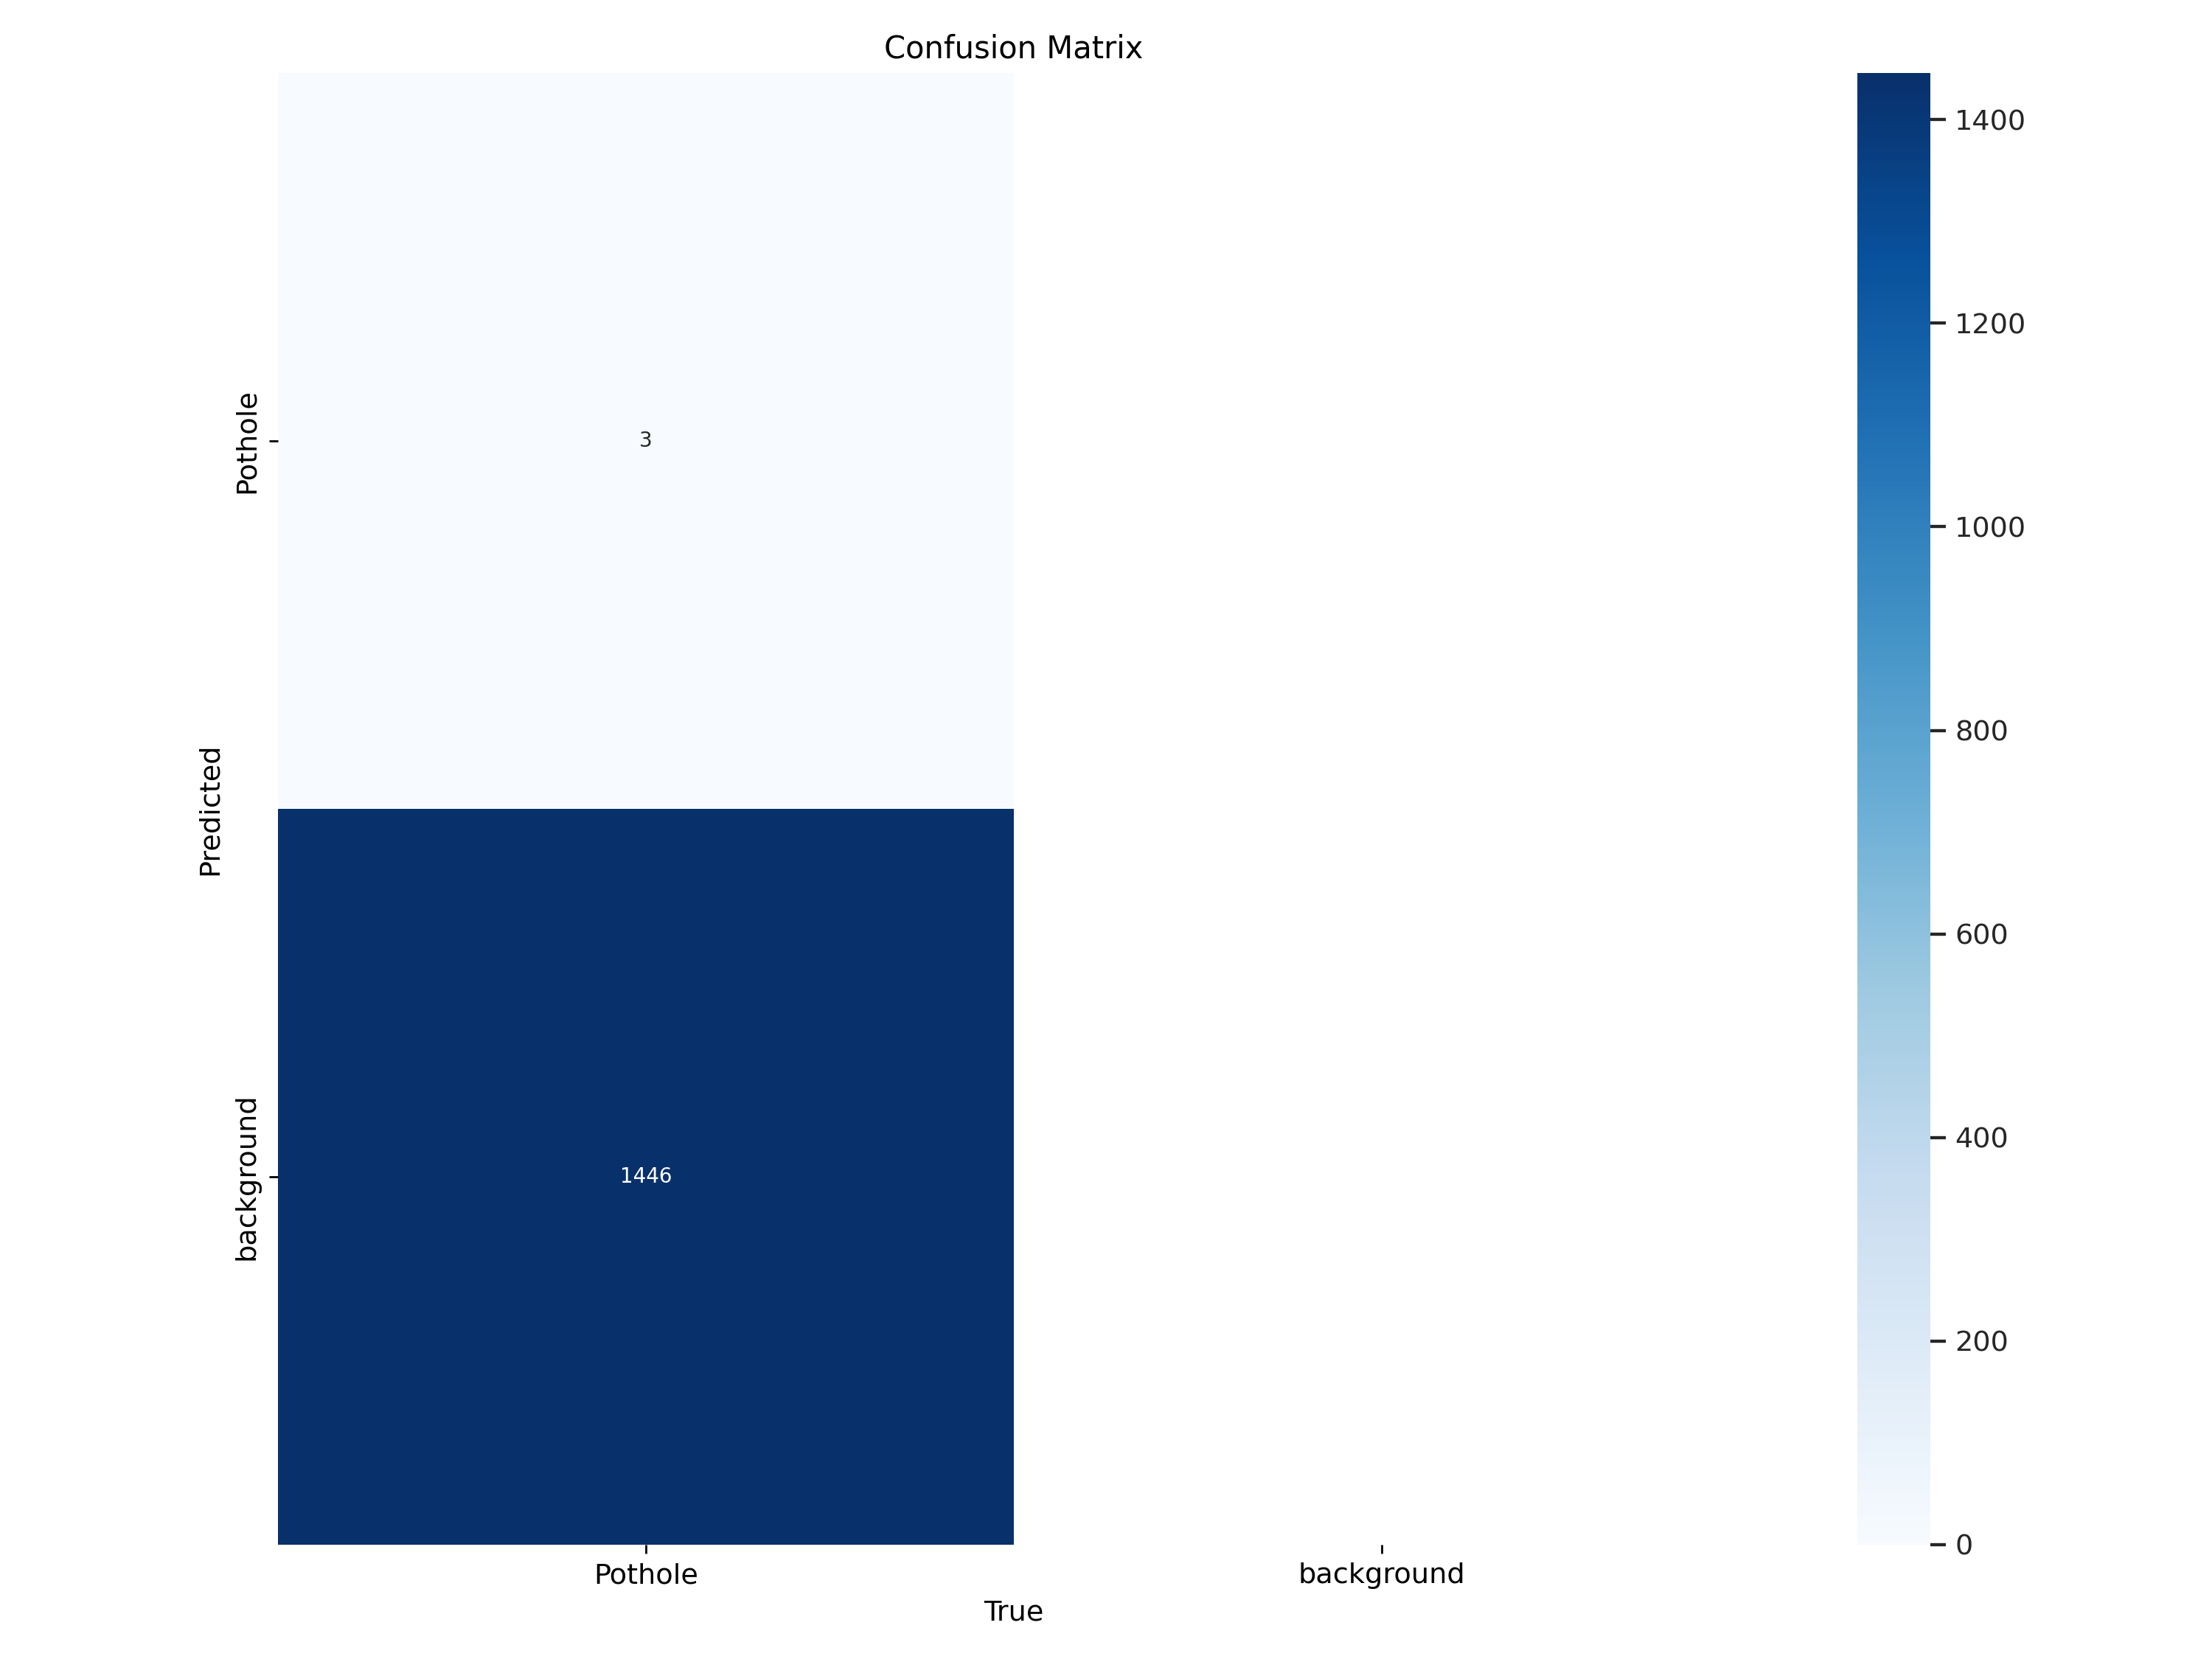

In [10]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

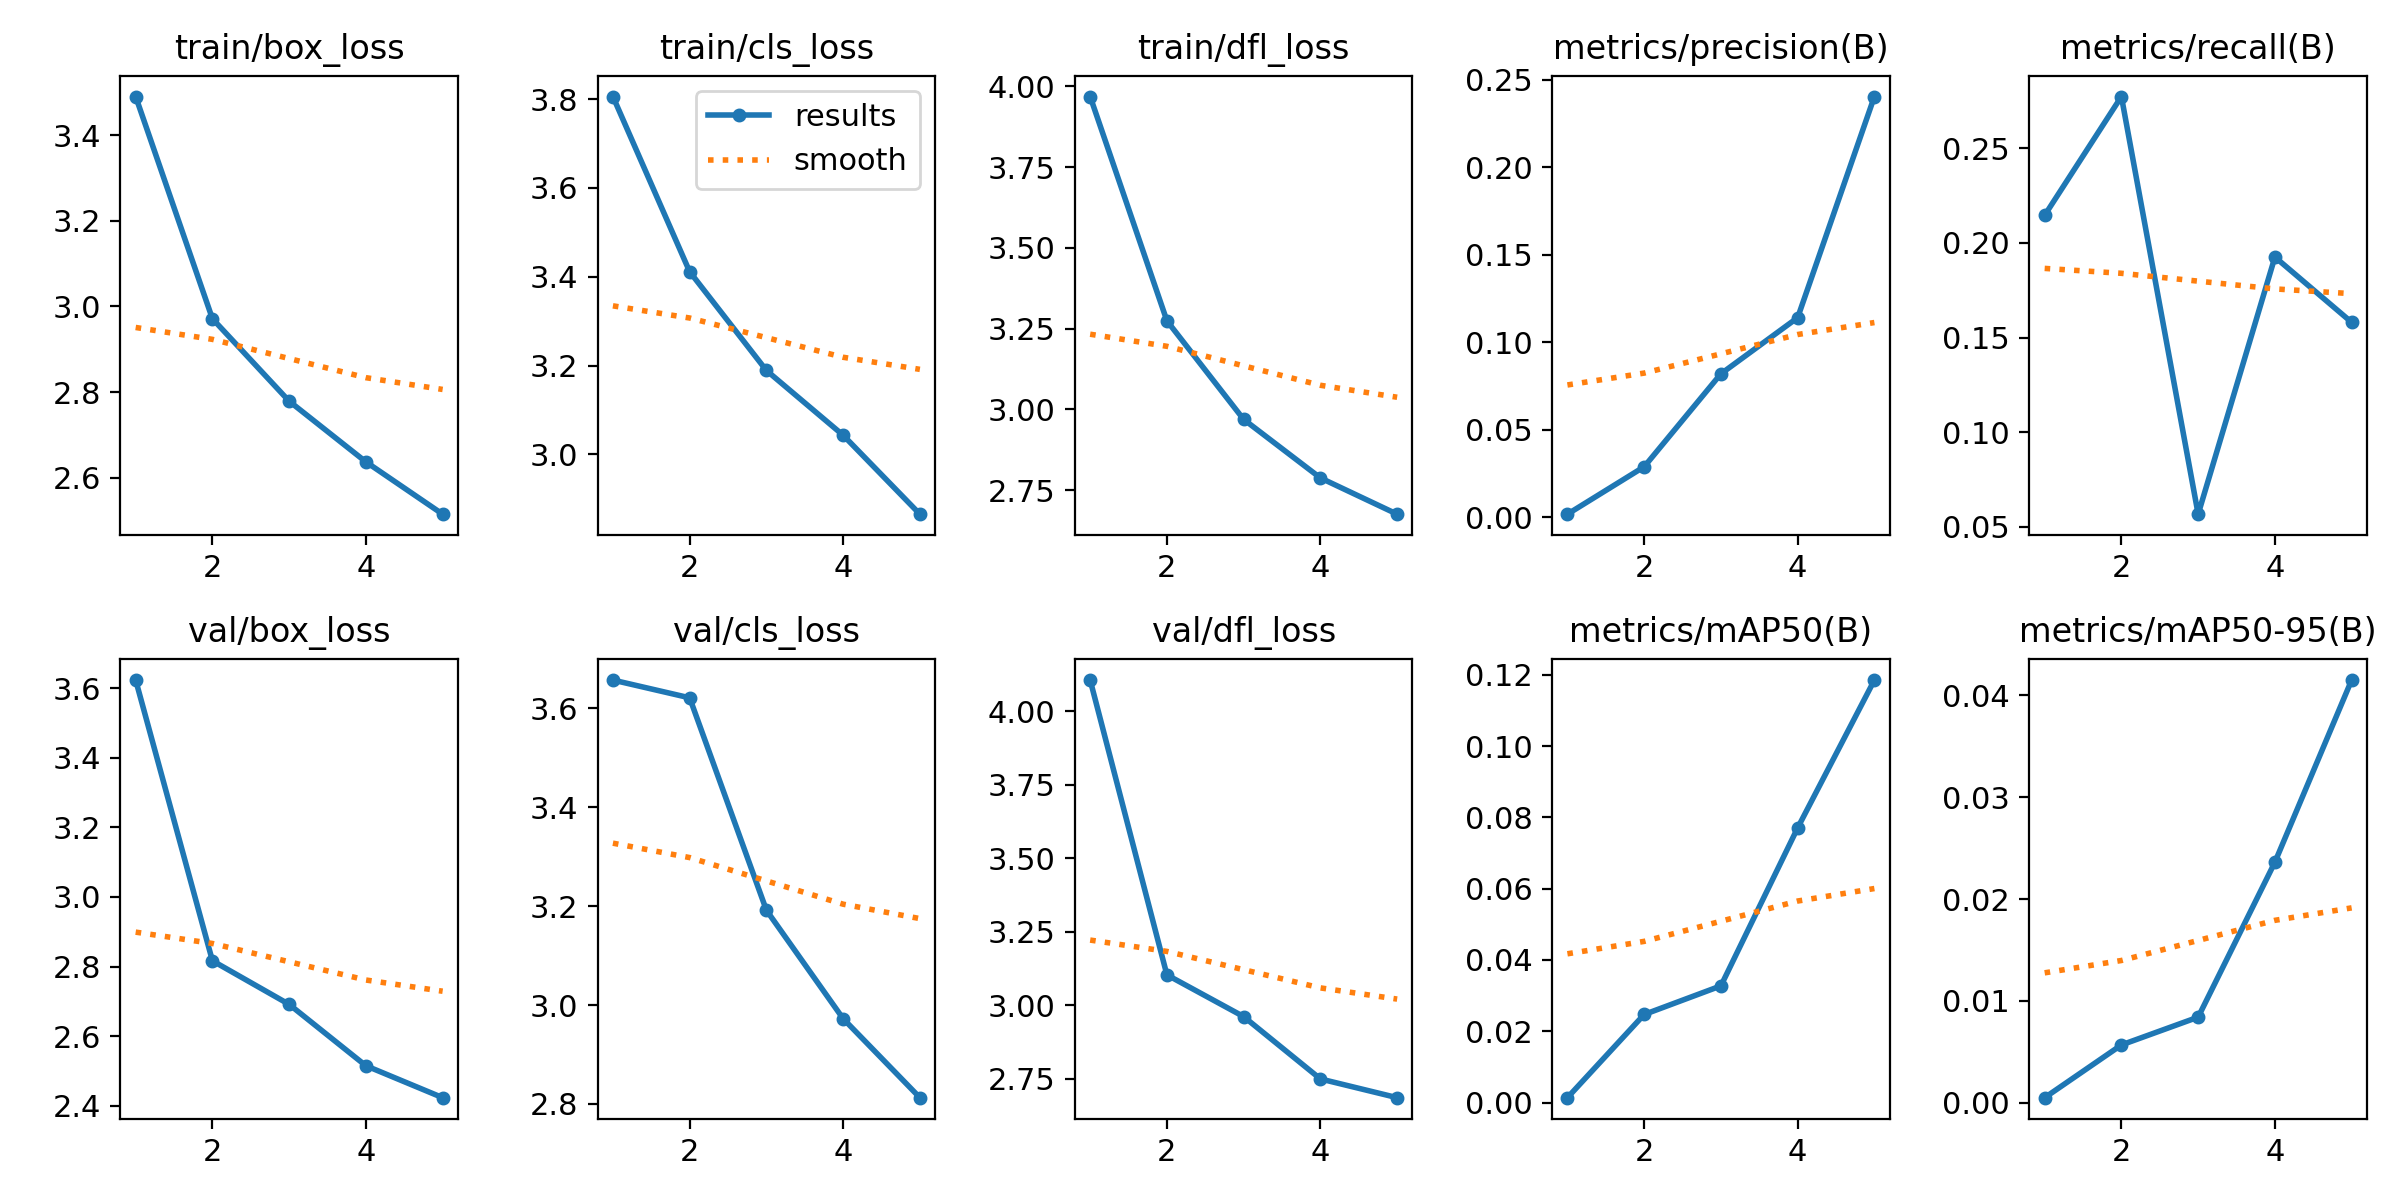

In [21]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [22]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Pothole']

In [23]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [24]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.00594059405940594
mAP 50 0.0099009900990099
mAP 75 0.0099009900990099


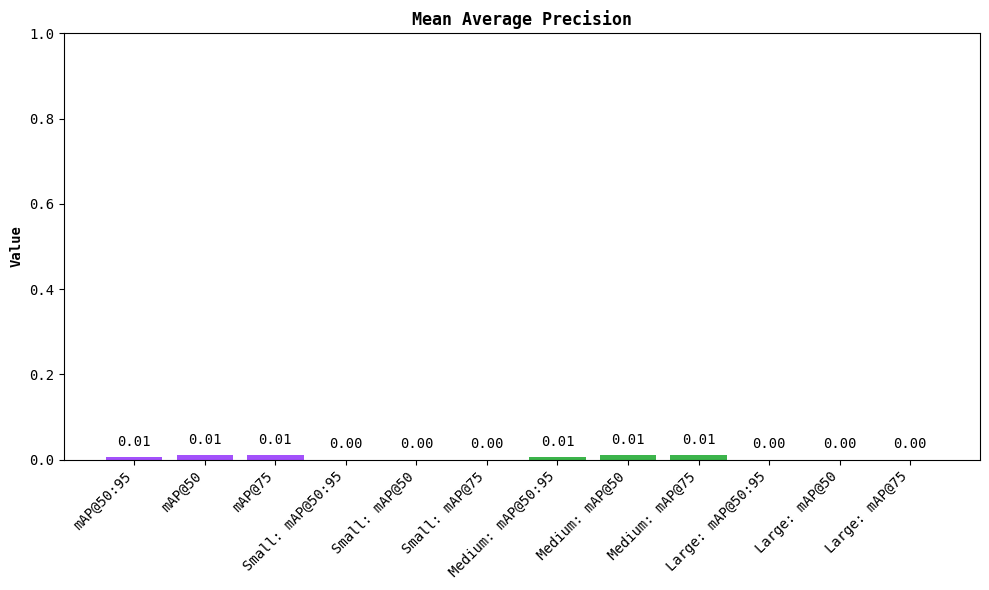

In [25]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [27]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

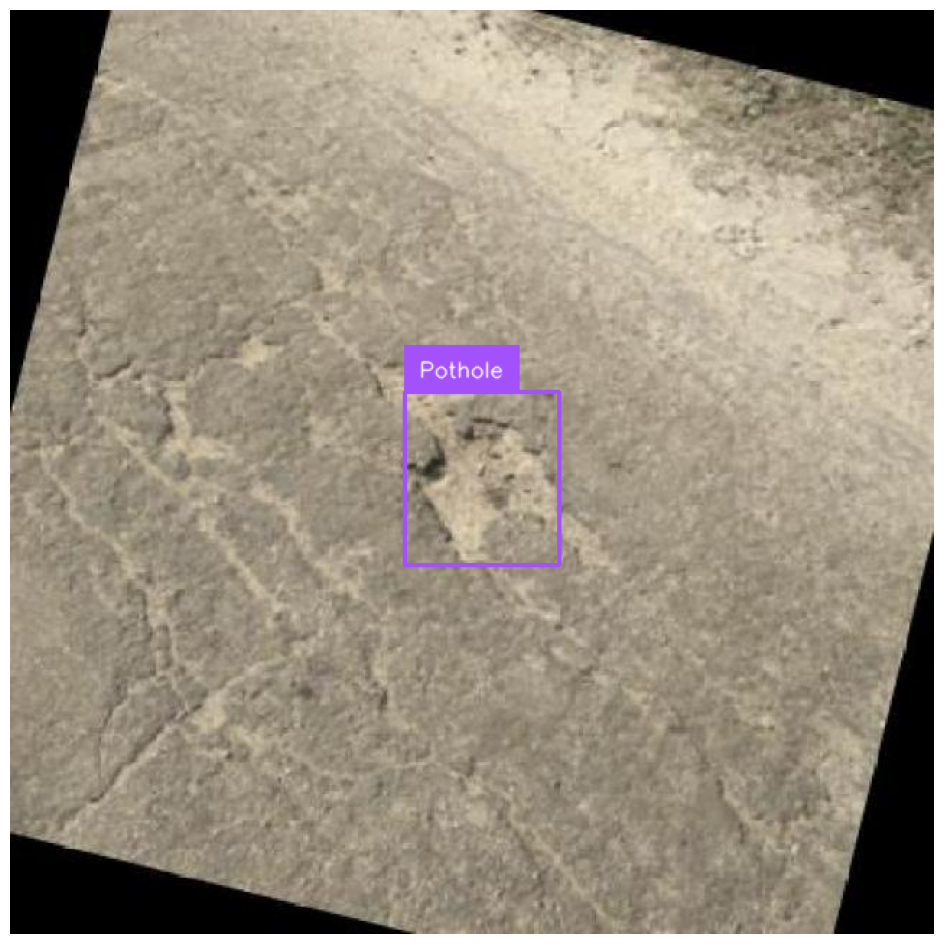

In [28]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

### Upload your image for inference

You can upload your image using the file icon in the left sidebar of Google Colab, or by running a command like `files.upload()` from `google.colab`. Once uploaded, replace `your_image_name.jpg` in the next code cell with the actual name of your uploaded image file.

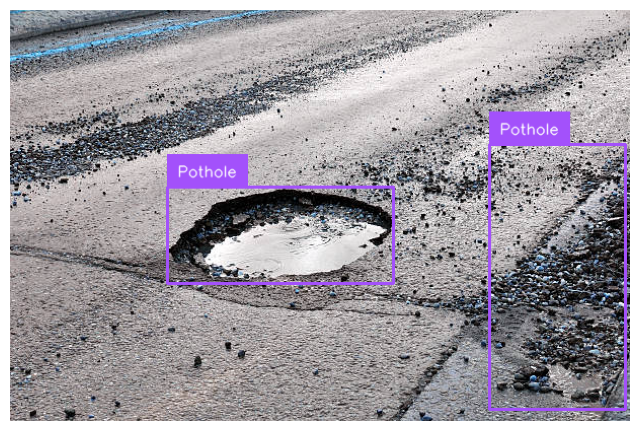

In [29]:
from google.colab import files

# This will prompt you to upload files
# uploaded = files.upload()

# After uploading, specify the path to your image
# For example, if you uploaded 'my_pothole_image.jpg', set the path below:
image_path_for_inference = "/MicrosoftTeams-image_32.jpg" # <-- REPLACE THIS WITH YOUR UPLOADED IMAGE FILE NAME

import cv2
import supervision as sv
from ultralytics import YOLO

# Load the image
image_for_inference = cv2.imread(image_path_for_inference)
image_for_inference = cv2.cvtColor(image_for_inference, cv2.COLOR_BGR2RGB)

# Load the fine-tuned model
model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

# Perform inference
results = model(image_for_inference, verbose=False)[0]
detector = sv.Detections.from_ultralytics(results).with_nms()

# Annotate the image
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image_for_inference = image_for_inference.copy()
annotated_image_for_inference = box_annotator.annotate(scene=annotated_image_for_inference, detections=detector)
annotated_image_for_inference = label_annotator.annotate(scene=annotated_image_for_inference, detections=detector)

# Display the annotated image
sv.plot_image(annotated_image_for_inference, size=(8,8))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')